[Frobenius] Best sequence: ((0, 90), (0, 180), (2, -90)) with error 32.37 degrees
[Quaternion] Best sequence: ((0, -90), (2, -90)) with error 32.37 degrees
[Axiswise] Best sequence: ((0, -90), (2, -90)) with error 77.89 degrees


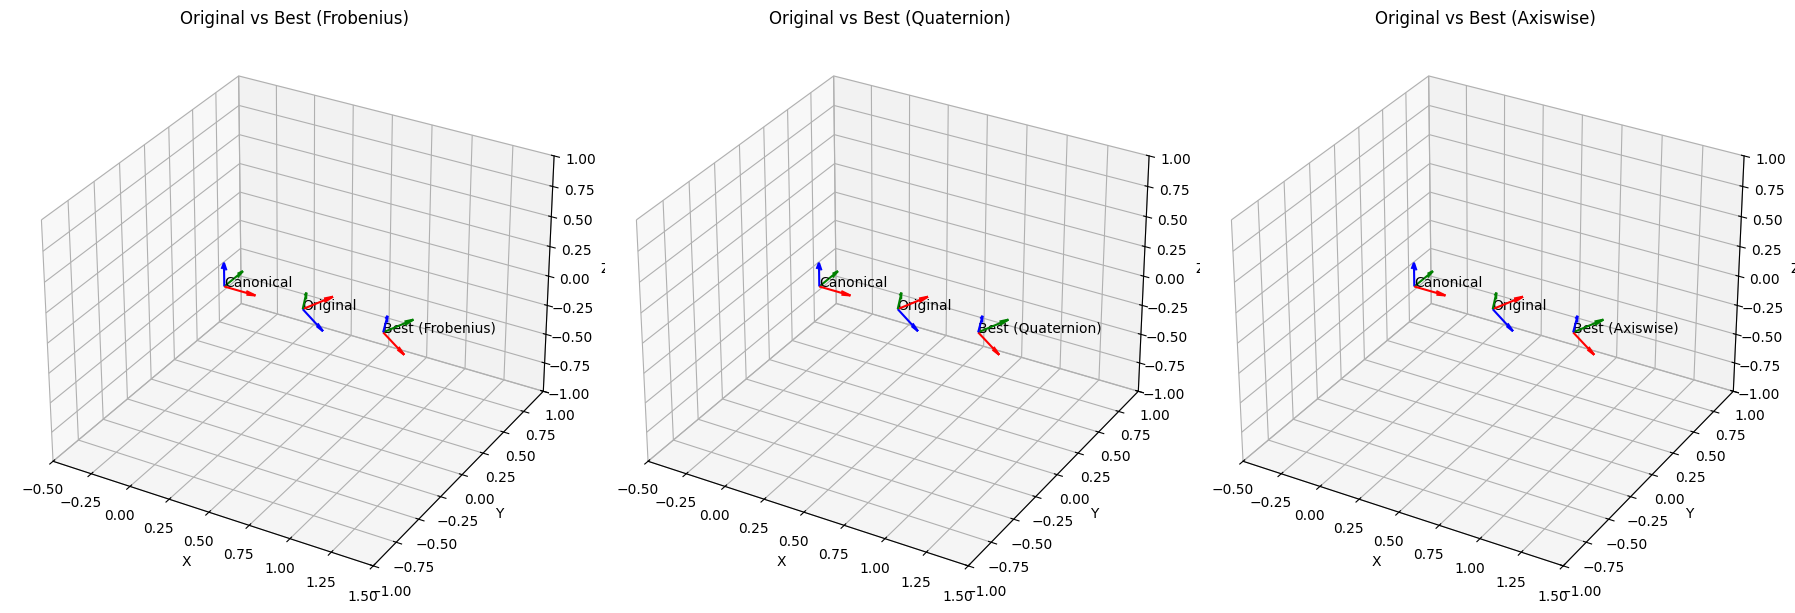

In [44]:
import numpy as np
import itertools
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R

def generate_random_rotation():
    """Generate a random rotation matrix."""
    return R.random().as_matrix()

def rotation_about_axis(axis, angle_deg):
    """Return a rotation matrix for a given axis (0=x, 1=y, 2=z) and angle in degrees."""
    angle_rad = np.deg2rad(angle_deg)
    if axis == 0:  # x-axis
        R_axis = np.array([[1, 0, 0],
                           [0, np.cos(angle_rad), -np.sin(angle_rad)],
                           [0, np.sin(angle_rad),  np.cos(angle_rad)]])
    elif axis == 1:  # y-axis
        R_axis = np.array([[ np.cos(angle_rad), 0, np.sin(angle_rad)],
                           [0, 1, 0],
                           [-np.sin(angle_rad), 0, np.cos(angle_rad)]])
    elif axis == 2:  # z-axis
        R_axis = np.array([[np.cos(angle_rad), -np.sin(angle_rad), 0],
                           [np.sin(angle_rad),  np.cos(angle_rad), 0],
                           [0, 0, 1]])
    else:
        raise ValueError("Axis must be 0 (x), 1 (y), or 2 (z)")
    return R_axis

# Define the available rotations
def get_available_moves(step_angle=180):
    if step_angle == 180:
        angles = [180]
    elif step_angle == 90:
        angles = [90, -90, 180]
    else:
        raise ValueError("step_angle must be 90 or 180 degrees.")
    
    moves = []
    for axis in [0,1,2]:  # x,y,z
        for angle in angles:
            moves.append((axis, angle))  # move = (axis, angle)
    return moves


def apply_rotation_sequence(frame, sequence):
    """Apply a sequence of rotations to the frame."""
    rotated = frame.copy()
    for axis, angle in sequence:
        R_rot = rotation_about_axis(axis, angle)
        rotated = rotated @ R_rot  # Right multiplication = local frame rotation
    return rotated

def frame_alignment_error(rotated_frame):
    """Measure geodesic distance to canonical frame."""
    R_err = rotated_frame.T  # rotated_frame → identity
    rotation = R.from_matrix(R_err)
    return rotation.magnitude()

def quaternion_alignment_error(rotated_frame):
    """Measure quaternion distance to identity rotation."""
    q_rot = R.from_matrix(rotated_frame).as_quat()  # (x, y, z, w)
    q_identity = np.array([0, 0, 0, 1])  # identity quaternion
    dot = np.clip(np.abs(np.dot(q_rot, q_identity)), 0.0, 1.0)
    angle = 2 * np.arccos(dot)  # angle between quaternions
    return angle

def axis_alignment_error(rotated_frame):
    """Measure sum of axis-wise errors to canonical frame."""
    canonical_axes = np.eye(3)  # X = [1,0,0], Y = [0,1,0], Z = [0,0,1]
    error_sum = 0
    for i in range(3):  # for X, Y, Z
        rotated_axis = rotated_frame[:, i]
        canonical_axis = canonical_axes[:, i]
        dot = np.clip(np.dot(rotated_axis, canonical_axis), -1.0, 1.0)
        angle = np.arccos(dot)  # angle between vectors
        error_sum += angle
    return error_sum  # total axis misalignment

def plot_frames(ax, R_frame, label, origin=np.zeros(3), scale=0.2):
    """Plot a 3D coordinate frame."""
    colors = ['r', 'g', 'b']  # x=red, y=green, z=blue
    axes = np.eye(3)
    for i in range(3):
        vec = R_frame @ axes[:,i] * scale
        ax.quiver(*origin, *vec, color=colors[i], label=f"{label} {['X','Y','Z'][i]}")
    ax.text(*origin, label, fontsize=10, color='black')

# === MAIN ===

# np.random.seed(42)
arbitrary_frame = generate_random_rotation()

# Generate all sequences
moves = get_available_moves(step_angle=90)  # or 180
sequences = []
for n_moves in [1,2,3]:
    sequences += list(itertools.product(moves, repeat=n_moves))  # now product, not permutations

# Measure errors
errors_frobenius = []
errors_quaternion = []
errors_axiswise = []

for seq in sequences:
    rotated_frame = apply_rotation_sequence(arbitrary_frame, seq)
    err_frob = frame_alignment_error(rotated_frame)
    err_quat = quaternion_alignment_error(rotated_frame)
    err_axiswise = axis_alignment_error(rotated_frame)
    
    errors_frobenius.append((seq, err_frob))
    errors_quaternion.append((seq, err_quat))
    errors_axiswise.append((seq, err_axiswise))

# Find best
best_seq_frob, best_error_frob = min(errors_frobenius, key=lambda x: x[1])
best_seq_quat, best_error_quat = min(errors_quaternion, key=lambda x: x[1])
best_seq_axiswise, best_error_axiswise = min(errors_axiswise, key=lambda x: x[1])

print(f"[Frobenius] Best sequence: {best_seq_frob} with error {np.degrees(best_error_frob):.2f} degrees")
print(f"[Quaternion] Best sequence: {best_seq_quat} with error {np.degrees(best_error_quat):.2f} degrees")
print(f"[Axiswise] Best sequence: {best_seq_axiswise} with error {np.degrees(best_error_axiswise):.2f} degrees")

# Plot bar chart
# labels = [' '.join('XYZ'[ax] for ax in seq) for seq, _ in errors_frobenius]
# labels = [' '.join(f"{'XYZ'[ax]}({ang})" for ax, ang in seq) for seq, _ in errors_frobenius]
# error_vals_frob = [np.degrees(err) for _, err in errors_frobenius]
# error_vals_quat = [np.degrees(err) for _, err in errors_quaternion]
# error_vals_axiswise = [np.degrees(err) for _, err in errors_axiswise]

# fig, ax = plt.subplots(1,3, figsize=(18,6))

# ax[0].barh(labels, error_vals_frob)
# ax[0].set_xlabel('Alignment Error (degrees)')
# ax[0].set_title('Frobenius (Matrix Angle) Distance')
# ax[0].invert_yaxis()
# ax[0].grid(True)

# ax[1].barh(labels, error_vals_quat)
# ax[1].set_xlabel('Alignment Error (degrees)')
# ax[1].set_title('Quaternion Distance')
# ax[1].invert_yaxis()
# ax[1].grid(True)

# ax[2].barh(labels, error_vals_axiswise)
# ax[2].set_xlabel('Alignment Error (degrees)')
# ax[2].set_title('Axiswise Sum of Distances')
# ax[2].invert_yaxis()
# ax[2].grid(True)

# plt.tight_layout()
# plt.show()

fig = plt.figure(figsize=(18,6))
ax1 = fig.add_subplot(131, projection='3d')
ax2 = fig.add_subplot(132, projection='3d')
ax3 = fig.add_subplot(133, projection='3d')

ax1.set_title('Original vs Best (Frobenius)')
ax2.set_title('Original vs Best (Quaternion)')
ax3.set_title('Original vs Best (Axiswise)')

# Frobenius
plot_frames(ax1, np.eye(3), 'Canonical', origin=np.array([0,0,0]))
plot_frames(ax1, arbitrary_frame, 'Original', origin=np.array([0.5,0,0]))
best_rotated_frob = apply_rotation_sequence(arbitrary_frame, best_seq_frob)
plot_frames(ax1, best_rotated_frob, 'Best (Frobenius)', origin=np.array([1.0,0,0]))

# Quaternion
plot_frames(ax2, np.eye(3), 'Canonical', origin=np.array([0,0,0]))
plot_frames(ax2, arbitrary_frame, 'Original', origin=np.array([0.5,0,0]))
best_rotated_quat = apply_rotation_sequence(arbitrary_frame, best_seq_quat)
plot_frames(ax2, best_rotated_quat, 'Best (Quaternion)', origin=np.array([1.0,0,0]))

# Axiswise
plot_frames(ax3, np.eye(3), 'Canonical', origin=np.array([0,0,0]))
plot_frames(ax3, arbitrary_frame, 'Original', origin=np.array([0.5,0,0]))
best_rotated_axiswise = apply_rotation_sequence(arbitrary_frame, best_seq_axiswise)
plot_frames(ax3, best_rotated_axiswise, 'Best (Axiswise)', origin=np.array([1.0,0,0]))

for a in [ax1, ax2, ax3]:
    a.set_xlim([-0.5,1.5])
    a.set_ylim([-1,1])
    a.set_zlim([-1,1])
    a.set_xlabel('X')
    a.set_ylabel('Y')
    a.set_zlabel('Z')

plt.tight_layout()
plt.show()


[Frobenius] Best sequence: ((2, 90), (1, 180), (0, 180)) with error 49.10 degrees
[Quaternion] Best sequence: ((2, -90),) with error 49.10 degrees
[Axiswise] Best sequence: ((2, 90), (1, 180), (0, 180)) with error 114.28 degrees
Recovery error after applying inverse rotation: 96.759753 degrees


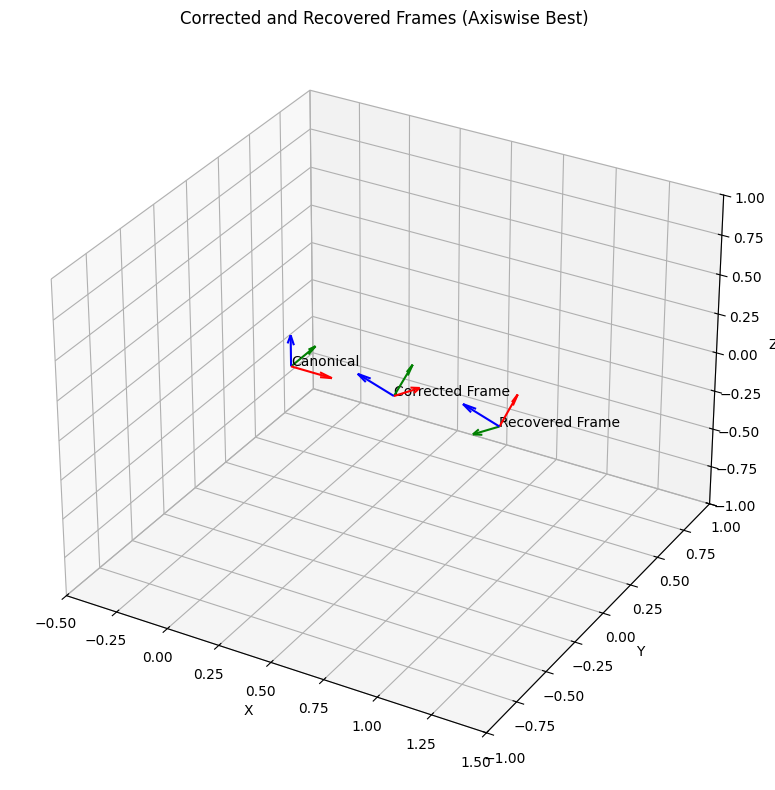

In [43]:
errors_frobenius = []
errors_quaternion = []
errors_axiswise = []
composed_rotations = {}  # Store R_total for each sequence

for seq in sequences:
    # Compose rotation matrix while applying
    R_total = np.eye(3)
    for axis, angle in seq:
        R_rot = rotation_about_axis(axis, angle)
        R_total = R_total @ R_rot
    
    rotated_frame = arbitrary_frame @ R_total  # Apply full rotation at once
    
    err_frob = frame_alignment_error(rotated_frame)
    err_quat = quaternion_alignment_error(rotated_frame)
    err_axiswise = axis_alignment_error(rotated_frame)
    
    errors_frobenius.append((seq, err_frob))
    errors_quaternion.append((seq, err_quat))
    errors_axiswise.append((seq, err_axiswise))
    composed_rotations[seq] = R_total  # Save it

# --- Find best ---
best_seq_frob, best_error_frob = min(errors_frobenius, key=lambda x: x[1])
best_seq_quat, best_error_quat = min(errors_quaternion, key=lambda x: x[1])
best_seq_axiswise, best_error_axiswise = min(errors_axiswise, key=lambda x: x[1])

print(f"[Frobenius] Best sequence: {best_seq_frob} with error {np.degrees(best_error_frob):.2f} degrees")
print(f"[Quaternion] Best sequence: {best_seq_quat} with error {np.degrees(best_error_quat):.2f} degrees")
print(f"[Axiswise] Best sequence: {best_seq_axiswise} with error {np.degrees(best_error_axiswise):.2f} degrees")

# --- Sanity check: recover canonical frame using inverse ---
best_sequence = best_seq_axiswise  # or whichever metric you prefer
R_best_total = composed_rotations[best_sequence]

# Corrected frame
best_rotated_frame = arbitrary_frame @ R_best_total

# Recovered frame (should be close to canonical)
recovered_frame = best_rotated_frame @ R_best_total.T  # inverse rotation

def frame_error_to_identity(frame):
    R_err = frame.T
    rotation = R.from_matrix(R_err)
    return rotation.magnitude()

recovery_error = frame_error_to_identity(recovered_frame)
print(f"Recovery error after applying inverse rotation: {np.degrees(recovery_error):.6f} degrees")

# --- Plot corrected and recovered frames ---
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')

plot_frames(ax, np.eye(3), 'Canonical', origin=np.array([0,0,0]))
plot_frames(ax, best_rotated_frame, 'Corrected Frame', origin=np.array([0.5,0,0]))
plot_frames(ax, recovered_frame, 'Recovered Frame', origin=np.array([1.0,0,0]))

ax.set_xlim([-0.5,1.5])
ax.set_ylim([-1,1])
ax.set_zlim([-1,1])
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Corrected and Recovered Frames (Axiswise Best)')
plt.tight_layout()
plt.show()


In [47]:
import numpy as np
import itertools
from spatialmath import SO3
from scipy.spatial.transform import Rotation as R

def optimize_frame_alignment(R_input, step_angle=90):
    """
    Find the best sequence of 90/-90/180 degree local rotations 
    to align an arbitrary frame as close as possible to canonical.

    Args:
        R_input (np.ndarray): 3x3 rotation matrix representing the arbitrary frame.
        step_angle (int): Default 90. Can be 90 or 180.

    Returns:
        np.ndarray: Best 3x3 rotation matrix to correct the input frame.
    """
    def frame_alignment_error(rotated_frame):
        R_err = rotated_frame.T  # rotated → identity
        rotation = R.from_matrix(R_err)
        return rotation.magnitude()

    # Define available moves
    if step_angle == 180:
        angles = [np.pi]  # 180 degrees
    elif step_angle == 90:
        angles = [np.pi/2, -np.pi/2, np.pi]  # 90, -90, 180
    else:
        raise ValueError("step_angle must be 90 or 180 degrees.")

    moves = []
    for axis in [0,1,2]:  # 0=X,1=Y,2=Z
        for angle in angles:
            moves.append((axis, angle))

    # Generate all sequences (1,2,3 moves)
    sequences = []
    for n_moves in [1,2,3]:
        sequences += list(itertools.product(moves, repeat=n_moves))

    best_error = np.inf
    best_rotation = np.eye(3)

    for seq in sequences:
        R_total = np.eye(3)
        for axis, angle in seq:
            if axis == 0:
                R_step = SO3.Rx(angle).A
            elif axis == 1:
                R_step = SO3.Ry(angle).A
            elif axis == 2:
                R_step = SO3.Rz(angle).A
            R_total = R_total @ R_step
        
        rotated_frame = R_input @ R_total
        err = frame_alignment_error(rotated_frame)

        if err < best_error:
            best_error = err
            best_rotation = R_total

    return best_rotation

# Example usage
R_input = R.random().as_matrix()

R_correction = optimize_frame_alignment(R_input, step_angle=90)

# Check recovery
R_corrected = R_input @ R_correction
R_err = R.from_matrix(R_corrected.T)
print(f"Alignment error after correction: {np.degrees(R_err.magnitude()):.6f} degrees")


Alignment error after correction: 46.989942 degrees


In [49]:
import numpy as np
import itertools
from spatialmath import SO3
from scipy.spatial.transform import Rotation as R
import matplotlib.pyplot as plt

def optimize_and_correct_frame(R_input, step_angle=90):
    """
    Optimize rotation to align frame to canonical and return corrected frame.

    Args:
        R_input (np.ndarray): 3x3 rotation matrix representing arbitrary frame.
        step_angle (int): 90 (default) or 180 degrees allowed.

    Returns:
        np.ndarray: Corrected 3x3 rotation matrix (after applying best correction).
    """
    def frame_alignment_error(R_frame):
        R_err = R_frame.T
        return R.from_matrix(R_err).magnitude()

    angles = [np.pi] if step_angle == 180 else [np.pi/2, -np.pi/2, np.pi]
    moves = [(axis, angle) for axis in range(3) for angle in angles]

    best_error = np.inf
    best_rotation = np.eye(3)

    for n in [1,2,3]:
        for seq in itertools.product(moves, repeat=n):
            R_total = np.eye(3)
            for axis, angle in seq:
                if axis == 0: R_step = SO3.Rx(angle).A
                elif axis == 1: R_step = SO3.Ry(angle).A
                else: R_step = SO3.Rz(angle).A
                R_total = R_total @ R_step
            R_candidate = R_input @ R_total
            err = frame_alignment_error(R_candidate)
            if err < best_error:
                best_error = err
                best_rotation = R_total

    R_corrected = R_input @ best_rotation
    return R_corrected, best_rotation

def plot_frames_3d(R_input, R_corrected, R_best_rotation):
    """Plot canonical, input, corrected, and corrected-inverse frames."""
    def plot_frame(ax, R_frame, label, origin, scale=0.2):
        colors = ['r', 'g', 'b']
        for i in range(3):
            vec = R_frame[:,i] * scale
            ax.quiver(*origin, *vec, color=colors[i])
        ax.text(*origin, label, fontsize=10)

    fig = plt.figure(figsize=(10,8))
    ax = fig.add_subplot(111, projection='3d')

    # Frames
    plot_frame(ax, np.eye(3), 'Canonical', origin=np.array([0,0,0]))
    plot_frame(ax, R_input, 'Original', origin=np.array([0.5,0,0]))
    plot_frame(ax, R_corrected, 'Corrected', origin=np.array([1.0,0,0]))

    R_recovered = R_corrected @ R_best_rotation.T
    plot_frame(ax, R_recovered, 'Recovered', origin=np.array([1.5,0,0]))

    ax.set_xlim([-0.5,2.0])
    ax.set_ylim([-1.5,1.5])
    ax.set_zlim([-1.5,1.5])
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('Frame Alignment Visualization')
    plt.tight_layout()
    plt.show()



Input frame:
[[ 0.54440877  0.15420317  0.8245244 ]
 [-0.14631416  0.98534541 -0.08767318]
 [-0.82596081 -0.07290955  0.55899279]]
Corrected frame:
[[ 0.8245244   0.15420317 -0.54440877]
 [-0.08767318  0.98534541  0.14631416]
 [ 0.55899279 -0.07290955  0.82596081]]
Best correction rotation:
[[ 3.74939946e-33 -6.12323400e-17 -1.00000000e+00]
 [ 0.00000000e+00  1.00000000e+00 -6.12323400e-17]
 [ 1.00000000e+00  0.00000000e+00  3.74939946e-33]]
Recovery error after correction: 57.018140 degrees


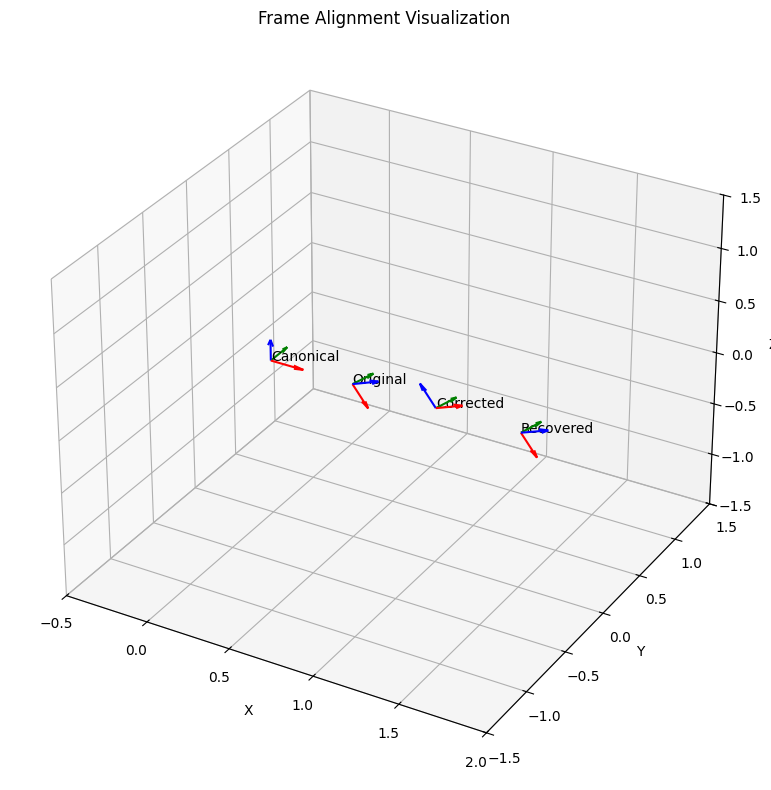

In [53]:
# Generate random frame
R_input = R.random().as_matrix()

# Optimize
R_corrected, R_best_rotation = optimize_and_correct_frame(R_input, step_angle=90)
print(f"Input frame:\n{R_input}")
print(f"Corrected frame:\n{R_corrected}")
print(f"Best correction rotation:\n{R_best_rotation}")
# Check recovery
R_recovered = R_corrected @ R_best_rotation.T
recovery_error = R.from_matrix(R_recovered.T).magnitude()
print(f"Recovery error after correction: {np.degrees(recovery_error):.6f} degrees")

# Plot
plot_frames_3d(R_input, R_corrected, R_best_rotation)
